In [40]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import idx2numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Task 1

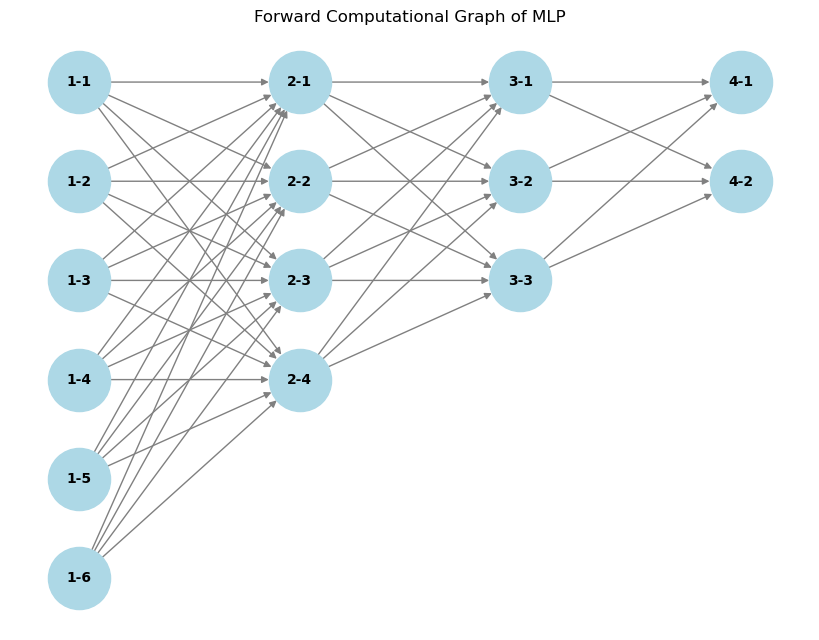

In [2]:
def draw_mlp_graph():
    layers = ["Input Layer", "Hidden Layer 1", "Hidden Layer 2", "Output Layer"]
    neurons = [6, 4, 3, 2]  # Given number of neurons per layer
    
    G = nx.DiGraph()
    node_positions = {}
    y_offset = 0
    node_labels = {}
    
    for layer_idx, (layer_name, num_neurons) in enumerate(zip(layers, neurons)):
        for i in range(num_neurons):
            node_id = f"{layer_idx+1}-{i+1}"
            G.add_node(node_id, layer=layer_idx)
            node_positions[node_id] = (layer_idx, -i + y_offset)
            node_labels[node_id] = node_id  # Label each neuron
        
    for l in range(len(layers) - 1):
        for i in range(neurons[l]):
            for j in range(neurons[l + 1]):
                G.add_edge(f"{l+1}-{i+1}", f"{l+2}-{j+1}")
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos=node_positions, with_labels=True, labels=node_labels, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Forward Computational Graph of MLP")
    plt.show()

draw_mlp_graph()

In [20]:
class MLP:
    def __init__(self, layers, activation="relu", learning_rate=0.01):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation_func = self.relu if activation == "relu" else self.sigmoid
        self.activation_deriv = self.relu_deriv if activation == "relu" else self.sigmoid_deriv
        
        # Initialize weights and biases
        self.weights = [np.random.randn(self.layers[i], self.layers[i - 1]) * np.sqrt(2 / self.layers[i - 1]) for i in range(1, len(layers))]
        self.biases = [np.zeros((n, 1)) for n in self.layers[1:]]
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_deriv(self, x):
        sig = self.sigmoid(x)
        return sig * (1 - sig)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(w, self.activations[-1]) + b
            self.z_values.append(z)
            if i == len(self.weights) - 1:
                self.activations.append(self.softmax(z))
            else:
                self.activations.append(self.activation_func(z))
        
        return self.activations[-1]
    
    def backward(self, X, Y):
        m = X.shape[1]
        dZ = self.activations[-1] - Y  # Softmax derivative
        
        dW = np.dot(dZ, self.activations[-2].T) / m
        dB = np.sum(dZ, axis=1, keepdims=True) / m
        
        self.weights[-1] -= self.learning_rate * dW
        self.biases[-1] -= self.learning_rate * dB
        
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = np.dot(self.weights[i + 1].T, dZ) * self.activation_deriv(self.z_values[i])
            dW = np.dot(dZ, self.activations[i].T) / m
            dB = np.sum(dZ, axis=1, keepdims=True) / m
            
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * dB
    
    def train_batch(self, X_batch, Y_batch):
        # Perform forward and backward pass for a single batch
        self.forward(X_batch)
        self.backward(X_batch, Y_batch)
    
    def train(self, X, Y, epochs=50, batch_size=32):
        losses = []
        accuracies = []
        
        for epoch in range(epochs):
            # Loop over batches
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i + batch_size].T  # Shape: (784, batch_size)
                Y_batch = Y[i:i + batch_size].T  # Shape: (10, batch_size)
                
                # Train on current batch
                self.train_batch(X_batch, Y_batch)

            # Evaluate training loss & accuracy after every epoch
            Y_pred = self.forward(X.T)
            loss = -np.mean(Y * np.log(Y_pred + 1e-8))
            losses.append(loss)
            
            predictions = np.argmax(Y_pred, axis=0)
            true_labels = np.argmax(Y, axis=0)
            accuracy = np.mean(predictions == true_labels)
            accuracies.append(accuracy)
            
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")
        
        return losses, accuracies
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=0)


## Task 2

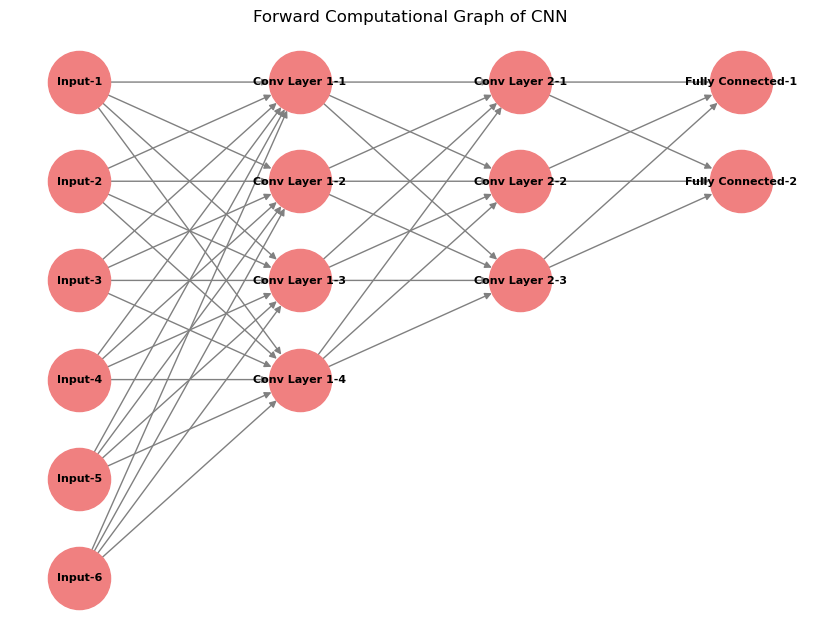

In [4]:
def draw_cnn_graph():
    G = nx.DiGraph()
    layers = ["Input", "Conv Layer 1", "Conv Layer 2", "Fully Connected"]
    neurons = [6, 4, 3, 2]
    node_positions = {}
    node_labels = {}
    
    for i, (layer, num) in enumerate(zip(layers, neurons)):
        for j in range(num):
            node_id = f"{layer}-{j+1}"
            G.add_node(node_id, layer=i)
            node_positions[node_id] = (i, -j)
            node_labels[node_id] = node_id
        
    for i in range(len(layers) - 1):
        for j in range(neurons[i]):
            for k in range(neurons[i + 1]):
                G.add_edge(f"{layers[i]}-{j+1}", f"{layers[i+1]}-{k+1}")
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos=node_positions, with_labels=True, labels=node_labels, node_size=2000, node_color='lightcoral', font_size=8, font_weight='bold', edge_color='gray')
    plt.title("Forward Computational Graph of CNN")
    plt.show()

draw_cnn_graph()

In [34]:
class CNN:
    def __init__(self, input_shape, num_filters, kernel_size, num_classes=10, activation="relu"):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.num_classes = num_classes
        self.activation_func = self.relu if activation == "relu" else self.sigmoid
        self.filters = np.random.randn(num_filters, kernel_size, kernel_size) * 0.01
        self.fc_weights = np.random.randn(num_filters * (input_shape[0] - kernel_size + 1) * (input_shape[1] - kernel_size + 1), num_classes) * 0.01
        self.fc_biases = np.zeros((num_classes, 1))
        self.learning_rate = 0.01
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Subtract max for numerical stability
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)

    def convolve(self, X):
        batch_size = X.shape[0]
        height, width = X.shape[1], X.shape[2]
        output = np.zeros((batch_size, height - self.kernel_size + 1, width - self.kernel_size + 1, self.num_filters))
        
        for b in range(batch_size):
            for f in range(self.num_filters):
                for i in range(output.shape[1]):
                    for j in range(output.shape[2]):
                        region = X[b, i:i+self.kernel_size, j:j+self.kernel_size]
                        output[b, i, j, f] = np.sum(region * self.filters[f])
        
        return self.activation_func(output)
    
    def flatten(self, X):
        return X.reshape(X.shape[0], -1)
    
    def fc_forward(self, X):
        return np.dot(X, self.fc_weights) + self.fc_biases
    
    def forward(self, X):
        conv_out = self.convolve(X)
        flattened = self.flatten(conv_out)
        output = self.fc_forward(flattened)
        return output, flattened, conv_out

    def compute_loss(self, output, Y):
        # Compute the softmax loss
        m = Y.shape[0]
        log_probs = np.log(output + 1e-8)  # To prevent log(0)
        loss = -np.sum(Y * log_probs) / m
        return loss

    def backward(self, X, Y, output, flattened, conv_out):
        m = X.shape[0]
        
        # Compute the gradient of the output layer
        dZ_output = output - Y  # Gradient of loss w.r.t. output
        dW_output = np.dot(flattened.T, dZ_output) / m
        dB_output = np.sum(dZ_output, axis=0, keepdims=True) / m
        
        # Compute the gradient of the fully connected layer
        d_flattened = np.dot(dZ_output, self.fc_weights.T)
        d_flattened[flattened <= 0] = 0  # ReLU backward pass
        
        # Reshape gradient of flattened back to the convolution output shape
        d_conv_out = d_flattened.reshape(conv_out.shape)
        
        # Backpropagate the gradient through the convolution layer
        d_filters = np.zeros_like(self.filters)
        for b in range(m):
            for f in range(self.num_filters):
                for i in range(d_conv_out.shape[1]):
                    for j in range(d_conv_out.shape[2]):
                        region = X[b, i:i+self.kernel_size, j:j+self.kernel_size]
                        d_filters[f] += region * d_conv_out[b, i, j, f]
        
        # Update weights and biases using the gradients
        self.fc_weights -= self.learning_rate * dW_output
        self.fc_biases -= self.learning_rate * dB_output
        self.filters -= self.learning_rate * d_filters
        
    def train_batch(self, X_batch, Y_batch):
        # Perform forward pass
        output, flattened, conv_out = self.forward(X_batch)
        
        # Compute the loss
        loss = self.compute_loss(self.softmax(output), Y_batch)
        
        # Perform backward pass and update weights
        self.backward(X_batch, Y_batch, output, flattened, conv_out)
        
        return loss

    def train(self, X, Y, epochs=50, batch_size=32):
        num_batches = X.shape[0] // batch_size
        
        for epoch in range(epochs):
            total_loss = 0
            for i in range(num_batches):
                X_batch = X[i*batch_size:(i+1)*batch_size]
                Y_batch = Y[i*batch_size:(i+1)*batch_size]
                
                loss = self.train_batch(X_batch, Y_batch)
                total_loss += loss
            
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / num_batches}")

    def predict(self, X):
        output, _, _ = self.forward(X)
        return np.argmax(self.softmax(output), axis=1)


## Task 3
### MPL model

Epoch 1/50 - Loss: 0.0819 - Accuracy: 0.7970
Epoch 2/50 - Loss: 0.0498 - Accuracy: 0.8671
Epoch 3/50 - Loss: 0.0393 - Accuracy: 0.8884
Epoch 4/50 - Loss: 0.0340 - Accuracy: 0.9019
Epoch 5/50 - Loss: 0.0306 - Accuracy: 0.9103
Epoch 6/50 - Loss: 0.0282 - Accuracy: 0.9176
Epoch 7/50 - Loss: 0.0263 - Accuracy: 0.9231
Epoch 8/50 - Loss: 0.0248 - Accuracy: 0.9275
Epoch 9/50 - Loss: 0.0234 - Accuracy: 0.9311
Epoch 10/50 - Loss: 0.0223 - Accuracy: 0.9343
Epoch 11/50 - Loss: 0.0213 - Accuracy: 0.9360
Epoch 12/50 - Loss: 0.0203 - Accuracy: 0.9391
Epoch 13/50 - Loss: 0.0194 - Accuracy: 0.9416
Epoch 14/50 - Loss: 0.0186 - Accuracy: 0.9450
Epoch 15/50 - Loss: 0.0179 - Accuracy: 0.9469
Epoch 16/50 - Loss: 0.0172 - Accuracy: 0.9489
Epoch 17/50 - Loss: 0.0165 - Accuracy: 0.9497
Epoch 18/50 - Loss: 0.0159 - Accuracy: 0.9517
Epoch 19/50 - Loss: 0.0153 - Accuracy: 0.9545
Epoch 20/50 - Loss: 0.0147 - Accuracy: 0.9564
Epoch 21/50 - Loss: 0.0142 - Accuracy: 0.9587
Epoch 22/50 - Loss: 0.0137 - Accuracy: 0.96

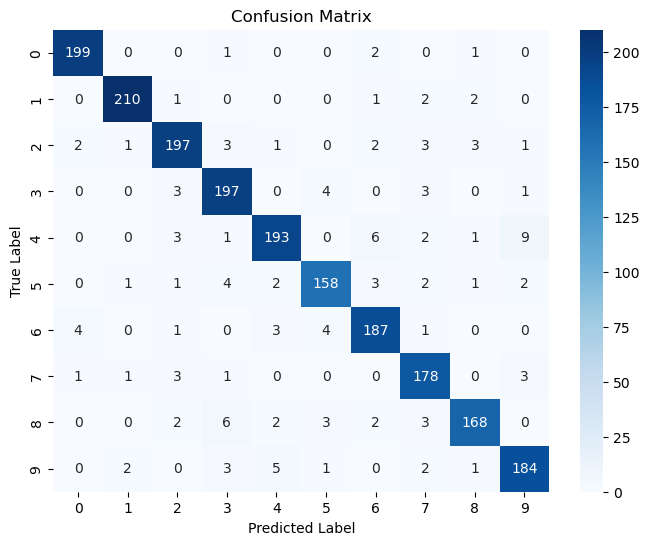

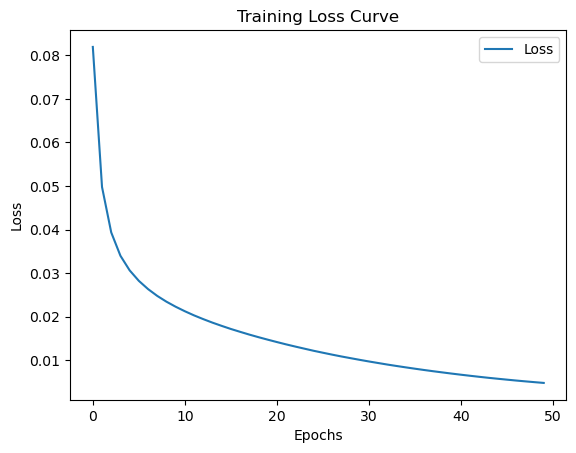

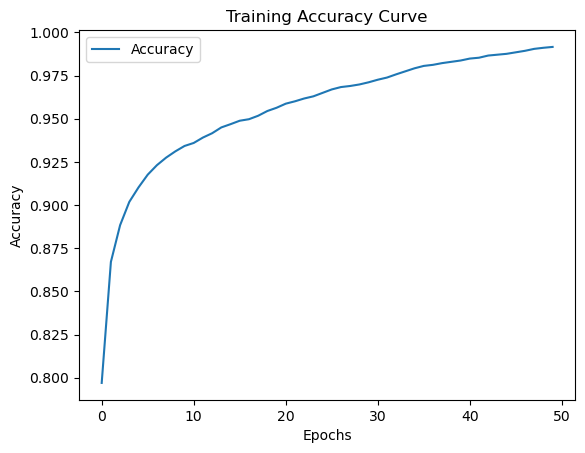

In [21]:
# File paths
train_images_path = r"C:\Users\nkras\OneDrive - University of Copenhagen\Fysik\129L\sec9b\train_images\t10k-images-idx3-ubyte"
train_labels_path = r"C:\Users\nkras\OneDrive - University of Copenhagen\Fysik\129L\sec9b\train_labels\t10k-labels-idx1-ubyte"

# Load images and labels
X = idx2numpy.convert_from_file(train_images_path)
Y = idx2numpy.convert_from_file(train_labels_path)

# Normalize pixel values (0-255 -> 0-1)
X = X.astype(np.float32) / 255.0

# Flatten images (28x28 -> 784)
X = X.reshape(X.shape[0], 28 * 28)  # Correct shape: (num_samples, 784)

# One-hot encode labels
Y_one_hot = np.eye(10)[Y]  # Shape: (num_samples, 10)

# Train-test split (80-20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=42)

# Initialize and train MLP
mlp = MLP(layers=[784, 128, 64, 10], activation="relu", learning_rate=0.01)

epochs = 50
batch_size = 32
loss_history = []
accuracy_history = []

for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):  # Use shape[0] for samples
        X_batch = X_train[i:i+batch_size].T  # Shape: (784, batch_size)
        Y_batch = Y_train[i:i+batch_size].T  # Shape: (10, batch_size)

        mlp.train_batch(X_batch, Y_batch)

    # Evaluate training loss & accuracy
    predictions = mlp.forward(X_train.T)  # Shape: (10, num_samples)

    loss = -np.mean(Y_train.T * np.log(predictions + 1e-8))  # Correct broadcasting
    loss_history.append(loss)

    accuracy = np.mean(np.argmax(predictions, axis=0) == np.argmax(Y_train, axis=1))  # axis=1
    accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

# Evaluate on test set
test_predictions = mlp.forward(X_test.T)  # Shape: (10, num_test_samples)

test_accuracy = np.mean(np.argmax(test_predictions, axis=0) == np.argmax(Y_test, axis=1))  # axis=1
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot confusion matrix
y_true = np.argmax(Y_test, axis=1)  # axis=1
y_pred = np.argmax(test_predictions, axis=0)  # axis=0
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot loss curve
plt.figure()
plt.plot(range(epochs), loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# Plot accuracy curve
plt.figure()
plt.plot(range(epochs), accuracy_history, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()
plt.show()


### CNN

In [41]:
# Load MNIST dataset (same as before)
train_images_path = r"C:\Users\nkras\OneDrive - University of Copenhagen\Fysik\129L\sec9b\train_images\t10k-images-idx3-ubyte"
train_labels_path = r"C:\Users\nkras\OneDrive - University of Copenhagen\Fysik\129L\sec9b\train_labels\t10k-labels-idx1-ubyte"

X = idx2numpy.convert_from_file(train_images_path)
Y = idx2numpy.convert_from_file(train_labels_path)

# Normalize pixel values
X = X.astype(np.float32) / 255.0
X = X.reshape(X.shape[0], 28, 28)  # (num_samples, 28, 28)

# One-hot encode labels
Y_one_hot = np.eye(10)[Y]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=42)

# Initialize CNN model
cnn = CNN(input_shape=(28, 28), num_filters=3, kernel_size=3, num_fc_units=128, num_classes=10, activation="relu")

# Training the model
epochs = 10
batch_size = 32
loss_history = []
accuracy_history = []

for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        Y_batch = Y_train[i:i+batch_size]
        cnn.train_batch(X_batch, Y_batch)
    
    # Evaluate training loss and accuracy
    output, _, _ = cnn.forward(X_train)
    loss = -np.mean(Y_train * np.log(output + 1e-8))
    loss_history.append(loss)

    predictions = np.argmax(output, axis=1)  # Fix axis for predictions
    true_labels = np.argmax(Y_train, axis=1)
    accuracy = np.mean(predictions == true_labels)
    accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

# Evaluate on test set
output_test, _, _ = cnn.forward(X_test)
test_accuracy = np.mean(np.argmax(output_test, axis=1) == np.argmax(Y_test, axis=1))  # Fixed axis for test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot confusion matrix
y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(output_test, axis=1)  # Fixed axis for predictions
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot loss curve
plt.figure()
plt.plot(range(epochs), loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# Plot accuracy curve
plt.figure()
plt.plot(range(epochs), accuracy_history, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()
plt.show()


TypeError: __init__() got an unexpected keyword argument 'num_fc_units'